In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: Naive Bayes


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

Naive Bayes is a simple, yet computationally fast and often effective, probabilistic classification algorithm. Its name is due to the fact that it relies on Bayes' theorem; it is 'naive' as it naively assumes that all features are conditionally independent with each other. Although this is a strong assumption that rarely holds, this algorithm can still perform well, especially in large dimensions. 

For this notebook, students are supposed to have already seen in class the following concepts: 
* probability (marginal and conditional) 
* (in)dependent events and random variables
* conditional independence
* Bayes' theorem
* Naive Bayes 
* Count smoothing 

In this notebook, we are going to review the following concepts: 
1. Probability Review 
1. Naive Bayes
  * Categorical Naive Bayes 
  * Count smoothing
  * Multinomial Naive Bayes 
  * Gaussian Naive Bayes
1. Examples in Python
1. Example with the Heart Dataset 

## 1. Probability Review 

**Probability: Definition** According the the three *axioms of probability*, we can define a probability such as that quantity $P$ for which the following three axioms are always true: 
1. $0 \leq P \leq 1$
1. $P(A \cup B) = P(A) + P(B)$ (if $A$ and $B$ are *disjoint events*) 
1. $P(S) = 1$ (where $S$ is the whole *sampling space*) 

We can estimate a probability of an event as the fraction of times that the event occurs in the sampling space. For instance, if we had a urn with 5 green balls, 3 blue balls, and 2 red balls (10 balls in total): 

<img src="./img/naive_bayes/prob_1.png" width="200" height="50"/>

Then we can estimate $\Pr(Green)=1/2$, $\Pr(Blue)=3/10$, $\Pr(Red)=1/5$. 

<img src="./img/naive_bayes/pr_color.png" width="200" height="50"/>

Note that, for the second axiom above, $\Pr(Red\ OR\ Blue) = 1/5+3/10=1/2$, while for the third axiom $\Pr(Red\ OR\ Blue\ OR\ Green) = 1$. For this last axiom, it is also implied that $\Pr(Red)=1-\Pr(Red^C)=1-(1/2+3/10)=1/5$.

If we had *continuous* data, rather than categorical or count data, we can for example estimate their *mean* and *standard deviation*, and assume a probability distribution such as the Gaussian to estimate their *density* (note that the density function of continuous probability distributions do not return probabilities: they can be larger than 1). The density of the Gaussian evaluated at a point $x$ is defined as: 

$$ f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

The values of $\sigma^2$ and $\mu$ can be replaced with the estimate of the mean, $\hat{\mu} = \bar{x}$ and the square of the estimate of the standard deviation, $\hat{\sigma}^2$. 

<img src="./img/naive_bayes/pr_continuous.png" width="325" height="50"/>

**Joint Probability**. If we had data for $p>1$ (random) variables (r.v.) $X_1,...,X_p$, we can estimate the *joint probability* $\Pr(X_1,...,X_p)$ of such variables. For categorical data, consider the following table (here we consider $p=2$ variables, but the extension to more variables is straightforward): 


| Sex | Marital Status |
|:------:|:-----:|
| M | Married | 
| F | Married |  
| F | Single | 
| M | Single |
| F | Married | 

We have the following *marginal probabilities* (univariate probabilities): 
* $\Pr(Sex=M) = 2/5 $
* $\Pr(Sex=F) = 3/5$
* $\Pr(M.Status = Married) = 3/5$
* $\Pr(M.Status = Single) = 2/5$

and the following *joint probabilities*: 
* $\Pr(Sex=M, M.Status = Married) = 1/5 $
* $\Pr(Sex=M, M.Status = Single) = 1/5 $
* $\Pr(Sex=F, M.Status = Married) = 2/5 $
* $\Pr(Sex=F, M.Status = Single) = 1/5 $

Univariate probabilities are called marginals because they can be retrieved by summing the joint probabilities over all values of other variables. For example: 

$$\Pr(Sex=M) = \Pr(Sex=M, M.Status = Married) + \Pr(Sex=M, M.Status = Single).$$

In case of continuous data, we can calculate the variable-specific averages, the *covariance matrix*  of the variables, and impose multivariate continuous distributions, such as the multivariate Gaussian (for example). Here, we can see an example with $p=2$ variables, $X_1$ and $X_2$: 

<img src="./img/naive_bayes/joint_probability.png" width="650" height="50"/>

**Conditional Probability**. Given two (non-disjoint) events $A$ and $B$, the *conditional probability* of $A$ given $B$ is:

$$\Pr(A|B) = \frac{\Pr(A,B)}{\Pr(B)}$$. 

For three events $A$, $B$, and $C$, the conditional probability of $A,B$ given $C$ is: 

$$\Pr(A,B|C) = \frac{\Pr(A,B, C)}{\Pr(C)}$$

and similarly, for $p$ r.v.'s, the conditional distribution $X_1,...,X_{p-1}|X_p$ is defined as $\frac{\Pr(X_1,..,X_{p-1}, X_p)}{X_p}.$ Note also that 


<br>
$\Pr(X_p)\Pr(X_1,...,X_{p-1}|X_p) = \Pr(X_1,...,X_p)$.
<br>


Coming back to the *Sex*, *Marital Status* table, we can estimate the following probabilities of the marital status, conditioned on $Sex=M$:

* $\Pr(M.Status = Married|Sex=M) = \frac{1/5}{2/5} = \frac{1}{2}$
* $\Pr(M.Status = Single|Sex=M) = \frac{1/5}{2/5} = \frac{1}{2}$

Continuous r.v.'s can be also conditioned, either on other continuous variables, or on categorical ones. In the following plot, you can see an example of conditioning a r.v. $X$ (which can be measurements about weights or heights in a population, for instance) on two groups, defined by the Sex of the units. On the left, you see the Gaussian of the *marginal* distribution of $X$, while on the right you see the group-specific (conditional) Gaussians.  

<img src="./img/naive_bayes/conditional_gaussian.png" width="650" height="50"/>

**Independence**. Two events $A$ and $B$ are said to be *independent* if 

$$\Pr(A,B) = \Pr(A)\Pr(B)$$

that is, their joint probability is equal to the product of their marginal probabilities. (Independence is denoted with $A{\perp\!\!\!\perp}B$.) This means that 

$$\Pr(A|B) = \Pr(A).$$

Two r.v.'s $X_1$ and $X_2$ are independent if $\Pr(X_1=x_1, X_2=x_2) =\Pr(X_1=x_1)\Pr(X_X=x_2)$ for all $x_1, x_2$ of the sampling space. We can easily extend the concept of independence to more than two events and r.v.'s. In case of random variables, $X_1$, $X_2$ and $X_3$ are independent with each other iff: 

$$\Pr(X_1, X_2, X_3) = \Pr(X_1)\Pr(X_2)\Pr(X_3)$$

for all $x_1$, $x_2$, $x_3$ of their sampling space. 

Let's go back again to the example of the table of *Sex* and *Marital Status*; in this case, Sex and Marital Status are not independent. For example: 

$$\Pr(M.Status = Married,Sex=M) = 1/5$$
$$\Pr(M.Status = Married)\Pr(Sex = M) = 3/5\cdot2/5 = 6/10 = 2/5$$

and therefore independence does not hold. This can also be seen by drawing the *barplot* of the distribution of *Marital Status*, marginal and conditioned on *Sex*: 

<img src="./img/naive_bayes/conditional_categorical.png" width="650" height="50"/>

As you can see, the marginal distribution of *Marital Status* is different from the ones observed for males and females. This means that the probability of *Marital Status* depends on the subject's *Sex*. However, if we had a contingency table that led to the following situation: 

<img src="./img/naive_bayes/categorical_independent.png" width="650" height="50"/>

then we would have two independent r.v.'s. 

In case of Gaussian data, we can examine the covariance matrix of the r.v.'s. If covariances (or equivalently the correlations) are equal to 0 (and thus we have a *diagonal covariance matrix*), then we do not have linear dependence among the variables; if covariances are different from 0, than variables are said to be linearly correlated. (Notice that lack of correlation does not imply lack of independence, as other types of relationships may be possible). In this plot, you can see two possible relationships for the bivariate ($X_1,X_2$) case: independent variables, and correlated variables. Notice that, in case of diagonal covariance matrix, the shape of the Gaussian distribution is *axis-aligned*, but it is not in case of linear relationships (non-diagonal covariance matrix). 

<img src="./img/naive_bayes/indep_dep_continuous.png" width="650" height="50"/>


**Conditional Independence**. Two events $A$ and $B$ are conditionally independent given a third event $C$ (denoted with $A{\perp\!\!\!\perp}B|C$) iff. 

$$\Pr(A,B|C) = \Pr(A|C)\Pr(B|C)$$

Similarly, the concept can be formulated for r.v.'s: 

$$\Pr(X_1,X_2|X_3) = \Pr(X_1|X_3)\Pr(X_2|X_3)$$

for all values of $x_1, x_2, x_3$. The concept can be extended to multiple events or r.v.'s. In case of 4 r.v.'s $X_1,...,X_4$ given $X_5$:

$$\Pr(X_1,X_2,X_3,X_4|X_5) = \Pr(X_1|X_5)\Pr(X_2|X_5)\Pr(X_3|X_5)\Pr(X_4|X_5).$$


Consider the following table: 

| Sex | Marital Status | Education | 
|:------:|:-----:|:-----:|
| M | Single | High School (HS) | 
| F | Single | Primary School (PS) |  
| F | Single | HS |  
| M | Married | PS |
| M | Single | PS |
| F | Married | HS |
| M | Married | HS | 
| F | Married | PS | 

Let's check if *Marital Status* is independent of *Education*, conditional on *Sex*: 
* $\Pr(Married,PS|M) = 1/4 = \Pr(Married|M)\Pr(PS|M) $
* $\Pr(Married,HS|M) = 1/4 = \Pr(Married|M)\Pr(HS|M) $
* $\Pr(Single, PS|M) = 1/4 = \Pr(Single|M)\Pr(PS|M) $
* $\Pr(Single, HS|M) = 1/4 = \Pr(Single|M)\Pr(HS|M) $
* $\Pr(Married,PS|F) = 1/4 = \Pr(Married|M)\Pr(PS|F) $
* $\Pr(Married,HS|F) = 1/4 = \Pr(Married|M)\Pr(HS|F) $
* $\Pr(Single, PS|F) = 1/4 = \Pr(Single|M)\Pr(PS|F) $
* $\Pr(Single, HS|F) = 1/4 = \Pr(Single|M)\Pr(HS|F) $

Thus, the two variables are conditionally independent! (Check the results by yourself.)

Also continuous variables can become conditionally independent. In the following plot, you can observe that, marginally, $X_1$ and $X_2$ appear to be correlated; however, correlations are lost once conditioned on *Sex*. 

<img src="./img/naive_bayes/cond_indep_continuous.png" width="650" height="50"/>


**Bayes' Theorem**. Bayes' theorem allows us to find the probability of a *hypothesis*, once an event has been observed (hence its alternative name *theorem of inverse probability*). This implies assuming a *prior* probability for the hypothesis. For a hypothesis $H$ and an observed event $E$, Bayes' theorem allows finding $\Pr(H|E)$: 

$$\Pr(H|E) = \frac{\Pr(H)\Pr(E|H)}{\Pr(E)}$$

where: 
* $\Pr(H)$ is the **prior** probability
* $\Pr(E|H)$ is the *likelihood*
* $\Pr(E)$ is known as **evidence** or **marginal likelihood**
* $\Pr(H|E)$ is the *posterior probability* of $H$

$\Pr(E)$ is called marginal likelihood because it is the probability of the event, marginalized over all possible hypotheses:

<br>
$$\Pr(E) = \Pr(H)\Pr(E|H) + \Pr(H^C)\Pr(E|H^C).$$
<br> 

For example, if $H$ is composed of 3 events, we would have: 

<br>
$$\Pr(E|H) = \Pr(H=1)\Pr(E|H=1) + \Pr(H=2)\Pr(E|H=2) + \Pr(H=3)\Pr(E|H=3).$$
<br>

For random variables, we can give a similar definition. In particular, given that the *likelihood* is given by $p \geq 1$ r.v.'s, we can state Bayes' theorem as: 

<br>
$$\Pr(H|X_1,...,X_p) = \frac{\Pr(H)\Pr(X_1,...,X_p|H)}{\Pr(H)\Pr(X_1,...,X_p|H)+\Pr(H^C)\Pr(X_1,...,X_p|H^C)} = \frac{\Pr(H)\Pr(X_1,...,X_p|H)}{\Pr(X_1,...,X_p)}$$
<br>

In case of continuous $X_1,...,X_p$, we can replace the value $\Pr(X_1,...,X_p|H)$ with the corresponding value of the multivariate density. 

Consider the following example. We have two urns, Urn 1 ($H=1$) with 4 blue ($E=B$) and 1 green ($E=G$) balls. And Urn 2 ($H=2$) with 2 blue and 3 green balls. We draw from one of the two urns a green ball. What is the probability that the ball was drawn from Urn 1? And what from Urn 2? 

<img src="./img/naive_bayes/urn_ball.png" width="350" height="50"/>

We have that: 

* $\Pr(H=1) = \Pr(H=2) = 1/2$ as the two urns contain the same number of balls
* $\Pr(E=B|H=1) = 4/5$, while $\Pr(E=B|H=2) = 2/5$
* $\Pr(E=G|H=1) = 1/5$, while $\Pr(E=G|H=2) = 3/5$

Therefore, by Bayes's theorem, the *posterior probability* of Urn 1 given that we have observed a green ball is: 

$$\Pr(H=1|E=G) = \frac{\Pr(H=1)\Pr(E=G|H=1)}{\Pr(E=G)}$$

which is calculated as: 

$$\Pr(H=1|E=G) = \frac{1/2\cdot1/5}{1/2\cdot1/5 + 1/2\cdot3/5} = \frac{1/10}{4/10} = \frac{1}{4}$$

On the other hand, the posterior probability of drawing a green ball from Urn 2 is:

$$\Pr(H=2|E=G) = \frac{\Pr(H=2)\Pr(E=G|H=2)}{\Pr(E=G)} = \frac{1/2\cdot3/5}{4/10} = \frac{3}{4} $$

The *posterior odd-ratios* are: 

$$\frac{\Pr(H=1|E=G)}{\Pr(H=2|E=G)} = \frac{1/4}{3/4} = 1/3 $$

which is 3-to-1 in favor of urn 2. (If this ratio was equal to 1, or equivalently the two posterior porbabilities equal to 0.5, then the two urns would have the same probabilities.)

## 2. Naive Bayes

**Generative vs. Discriminative Classifiers**. *Discriminative models* seek to learn the decision boundaries between the classes $Y$, for given values of the features $\mathbf{X}$. Probabilistically, they try to learn $\Pr(Y|\mathbf{X})$. *Logistic regression* is an example of discriminative classifier. *Generative models* seek to learn the joint distribution of the features and the classes, trying to model explicitly the distribution of the features within each class. In practice, they try to learn $\Pr(Y,\mathbf{X})$; usually this happens by estimating $\Pr(Y)$ and the conditional $\Pr(\mathbf{X}|Y)$, and then finding $\Pr(Y|\mathbf{X})$ with Bayes' theorem. *Naive Bayes* is an example of Generative Classifier. 

**Naive Bayes**. In order to be able to learn the (complex) probability distribution of $\Pr(\mathbf{X}|Y)$, generative models need to make some assumption to simplify calculations. Naive Bayes makes the following assumption: 

$$\Pr(X_1,X_2...,X_p|Y) = \Pr(X_1|Y)\Pr(X_2|Y)\cdots\Pr(X_p|Y)$$

which means the features are assumed to be conditionally independent, given the class: 

$$X_1{\perp\!\!\!\perp}X_2{\perp\!\!\!\perp}...{\perp\!\!\!\perp}X_p|Y$$ 

This assumption is very strong and does not hold usually; however, Naive Bayes can be very efficient in high dimensions, as it only needs to consider the univariate distributions of the features. Furthermore, predictions provided by Naive Bayes often work well in practice, since the posterior probabilities provided by this algorithm do not need to be precise, but rather assign data points to the correct side of the decision boundaries. 

**Model Form**. As already mentioned, Naive Bayes seeks to find the posterior probability $\Pr(Y|\mathbf{X})$ with the aid of Bayes' theorem. In particular, for $Y \in \{1,...,C\}$ the posterior probability of class $c$ is calculated as follows: 

<br>
$$\Pr(Y=c|X_1,...,X_p) = \frac{\Pr(Y=c)\Pr(X_1,...,X_p|Y=c)}{\Pr(X_1,...X_p)} = \frac{\Pr(Y=c)\Pr(X_1|Y=c)\cdots\Pr(X_P|Y=c)}{
\sum_{k=1}^{C} \Pr(Y=k)\Pr(X_1|Y=k)\cdots\Pr(X_p|Y=k)
}$$
<br>

for the conditional independence assumption. Such probabilities are estimated from the data (as explained in the next sections).  After the joint probabilities $\Pr(Y,\mathbf{X})$ have been computed (model training), predictions occur by assigning the units to the class $c$ such that 

$\Pr(Y=c|X_1,...,X_p)$

is maximized (or equivalently the class $c$ that maximizes $\Pr(Y=c)\Pr(X_1,...,X_p|Y=c) = \Pr(Y=c,\mathbf{X})$, since the marginal likelihood is the same for all classes). The *decision boundary* is given by all those point of $\mathbf{x}$ in which the classes have equal posterior probabilities. 

Depending on the nature of the features and on the assumptions made on the univariate distributions $\Pr(X_j|Y)_{j=1,...,p}$, we can have different types of Naive Bayes models. In particular: 

* we can use *categorical Naive Bayes* in presence of categorical data
* we can use *Multinomial Naive Bayes* in presence of count data, and Multinomial distributions are assumed
* we can use *Gaussian Naive Bayes* in presence of continuous data, and Gaussian distributions are assumed

In what follows, we are going to see the specific form of such models, as well as some examples. 


### 2.1 Categorical Naive Bayes 
Consider the *Contact Lenses Dataset*, reporting what type of contact lenses (the classes) an ophthalmologist should prescribe (n=*none*, s=*soft*, h=*hard*), given four nominal features: age (y=*young*, pp=*pre-presbyopic*, pr=*presbyopic*), spectacle prescription (m=*myope*, h=*hypermetrope*), astigmatism (y=*yes*, n=*no*), rate of tear production (r=*reduced*, n=*normal*). For this example, we consider only few observations of the dataset (in the Python examples, you will see the whole dataset): 

|ID| $X_1$: Age | $X_2$: Spectacle-Prescription |  $X_3$: Astigmatism | $X_4$: Tear-Prod Rate | $Y$: Contact Lenses|  
|:----:|:------:|:-----:|:-----:|:-----:|:-----:|
|1|y | m | n | r | n | 
|2|y| m | y| n | s | 
|3|pp | m | n | r | n | 
|4|pp | m | y | n | h | 
|5|pp | m | n | n | s | 
|6|pr | m | y | n | h | 
|7|y | h | n | r | n | 
|8| y | h | n | n | s | 
|9| y | h | y | n | h | 
|10| pp | h | n | n | s | 
|11| pr | h | n | n | s | 
|12|pr | h | y | r | n | 


**Training**. In presence of only nominal features, we can compute the class-specific counts of the categories of each variable, and subsequently turn such counts into probabilities. This is what *Categorical Naive Bayes* does.

In practice, it is assumed that each feature $X_j$ ($j=1,...,p$) follows a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution), and the $j$-th feature can take on $S_j \geq 2$ categories (in the case above, for example, $X_1$ has $S_1=3$ categories: $s \in \{y, pp, pr\}$). For the $s$-th category of $X_j$ , we estimate the probability: 

<br>
$$\Pr(X_j=s|Y=c) = \frac{\sum_{i:y_i=c}\mathcal{I}(x_{ij}=s)}{\sum_{i=1}^{n} \mathcal{I}(y_i=c)} \ \forall\ c, j, s$$
<br>

and $\mathcal{I}(a)$ is the indicator function, equal to $1$ when $a$ is True, and 0 otherwise. In words, this means that we perform this operation:


<br>
$$\Pr(X_j=s|Y=c) = \frac{\#\ of\ times\ category\ s\ of\ variable\ X_j\ is\ observed\ in\ the\ c-th\ class}
{\#\ of\ observations\ in\ class\ c}$$
<br>



With $p=2$ variables, the posterior probability of class $c$ given that $X_1 = s_1$ and $X_2 = s_2$ is observed, we would compute: 

<br>
$$\Pr(Y=c|X_1=s_1,X_2=s_2) = \frac{\Pr(Y=c)\Pr(X_1=s_1|Y=c)\Pr(X_2=s_2|Y=c)}{\sum_{k=1}^{C}Pr(Y=k)\Pr(X_1=s_1|Y=k)\Pr(X_2=s_2|Y=k)}
$$
<br>


Let's now manually train the model on the *contact lenses* data, by computing class counts and class-specific feature counts. First, let's start from the *prior probabilities* of $Y$: 

| |$Y$=n|$Y$=s|$Y$=h|Total|
|:------:|:------:|:------:|:------:|:------:|
|Count | 4 | 5 | 3 | 12 | 
|Pr(Y) | 4/12 | 5/12 | 3/12 | 1 | 
    

Now the counts for the class $Y=n$: 


|Counts, Y=n| $X_1$ | # | $X_2$ | # |   $X_3$ | #  | $X_4$ | # |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   2   |  $X_2$=m |  2   | $X_3$=n |   3  | $X_4$=r |  4    |
||  $X_1$=pp   |   1   |  $X_2$=h |  2   | $X_3$=y |   1  | $X_4$=n |  0    |
||  $X_1$=pr   |   1   |    |     |   |     |   |      |

<br>
that leads to the following estimated probabilities: 

|Pr, Y=n| $X_1$ | Pr | $X_2$ | Pr |   $X_3$ | Pr  | $X_4$ | Pr |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |  1/2    |  $X_2$=m |  1/2   | $X_3$=n |  3/4   | $X_4$=r |  1    |
||  $X_1$=pp   |   1/4   |  $X_2$=h |  1/2   | $X_3$=y |  1/4   | $X_4$=n |  0    |
||  $X_1$=pr   |   1/4   |    |     |   |     |   |      |


The counts for class $Y=s$: 


|Counts, Y=s| $X_1$ | # | $X_2$ | # |   $X_3$ | #  | $X_4$ | # |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |  2    |  $X_2$=m |  2   | $X_3$=n |  4   | $X_4$=r |   0   |
||  $X_1$=pp   |  2    |  $X_2$=h |  3   | $X_3$=y |  1   | $X_4$=n |   5   |
||  $X_1$=pr   |  1    |    |     |   |     |   |      |

<br>
with corresponding probabilities: 

|Pr, Y=s| $X_1$ | Pr | $X_2$ | Pr |   $X_3$ | Pr  | $X_4$ | Pr |   
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   2/5   |  $X_2$=m |  2/5   | $X_3$=n |  4/5   | $X_4$=r |  0    |
||  $X_1$=pp   |   2/5   |  $X_2$=h |  3/5   | $X_3$=y |  1/5   | $X_4$=n |   1   |
||  $X_1$=pr   |   1/5   |    |     |   |     |   |      |



Last, the counts for class $Y=h$: 

|Counts, Y=h| $X_1$ | # | $X_2$ | # |   $X_3$ | #  | $X_4$ | # |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   1   |  $X_2$=m |  3   | $X_3$=n |  0   | $X_4$=r |   0   |
||  $X_1$=pp   |   1   |  $X_2$=h |  0   | $X_3$=y |  3   | $X_4$=n |   3   |
||  $X_1$=pr   |   1   |    |     |     |     |   |      |

<br>
with estimated probabilities:

|Pr, Y=h| $X_1$ | Pr | $X_2$ | Pr |   $X_3$ | Pr  | $X_4$ | Pr |   
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   1/3   |  $X_2$=m |  1   | $X_3$=n |  0   | $X_4$=r |  0    |
||  $X_1$=pp   |   1/3   |  $X_2$=h |  0   | $X_3$=y |  1   | $X_4$=n |  1    |
||  $X_1$=pr   |   1/3   |    |     |   |     |   |      |


<br>
Done! Our Naive Bayes classifier is trained. According to the estimated probabilities, $X_2$ shouldn't be too discriminant for class $n$ (*none* contact lenses), but it could be highly discriminant for class $h$ (*hard* contact lenses). On the other hand, feature $X_4$ seems to be highly discriminant for all four classes. (Why is that? Try to give your own explanation, and see if you can detect other highly discriminant features for each class). 


**Note**. With the Naive Bayes algorithm we can directly work with multiple classes ($C>2$) (in this example we have three classes). Furthermore, in theory we do not need to one-hot encode the categorical features, as the model directly performs the counts of each category. In practice, libraries like scikit-learn still require encoded features, as we will see in the examples section.  



**Prediction**. Now, let's suppose we have a new observation $\mathbf{x}^*$ with the following characteristics: 

$$\mathbf{x}^* = \left(X_1=y, X_2=m, X_3=y, X_4=n\right) $$

How do we classify $\mathbf{x}^*$? Let's compute $\Pr(Y,\mathbf{x}^*)$ given $\mathbf{x}^*$.  


$$\Pr(Y=n, \mathbf{x}^*) = \frac{4}{12}\cdot\frac{1}{2}\cdot\frac{1}{2}\cdot\frac{1}{4}\cdot0 = 0$$

$$\Pr(Y=s, \mathbf{x}^*) = \frac{5}{12}\cdot\frac{2}{5}\cdot\frac{2}{5}\cdot\frac{1}{5}\cdot1 \approx 0.013$$

$$\Pr(Y=h, \mathbf{x}^*) = \frac{3}{12}\cdot\frac{1}{3}\cdot1\cdot1\cdot1 \approx 0.083 $$

Thus, the unit has a larger chance to be classified in the *hard contact lenses* class. We can also compute the posterior probabilities:

<br>
$$\Pr(Y=n|\mathbf{x}^*) = 0 $$
<br>
$$\Pr(Y=s|\mathbf{x}^*) = \frac{0.013}{0+0.013+0.083} \approx 0.135 $$
<br>
$$\Pr(Y=h|\mathbf{x}^*) = \frac{0.083}{0+0.013+0.083} \approx 0.865 $$
<br>

The new observation will then be classified into the *hard lenses* class. 



### 2.2 Count Smoothing
The posterior probability of class $n$ (*none contact lenses*) in this last example is equal to 0. This is due to the fact that, within the class *none contact lenses*, there was no observation having *Tear production rate=normal*. However, it seems quite implausible that in the whole population there won't be any patient having normal tear production rate, without contact lenses prescription ($Y=n$). In this case Naive Bayes is trained with probabilities that are too *sample-specific* (and therefore it is led to overfit). Note that the same problem may arise when we had to classify an observation having *reduced* tear production rate in the *soft* and *hard* contact lenses classes, or with *no astigmatism* in the same classes.  

To overcome the problem, there is a simple trick to avoid zero-counts in the features count tables: adding a number of imaginary counts, $\alpha > 0$, to each cell of the table. This will *smooth* the resulting probabilities, avoiding degenerate solutions as in the case above. For this reason, such operation is called *smoothing*. The new feature-specific probabilities are then computed as follows (remember that $S_j$ is the number of categories of feature $X_j$):

<br>
$$\Pr(X_j=s|Y=c) = \frac{\sum_{i:y_i=c}\mathcal{I}(x_{ij}=s) + \alpha}{\sum_{i=1}^{n} \mathcal{I}(y_i=c) + S_j\alpha}\ \forall\ c, j, s.$$
<br>

When $\alpha=1$, this is called *Laplace smoothing*. The solutions provided by Naive Bayes are in general quite robust to the choice of $\alpha$, but this can be seen as a tunable hyperparameter used to avoid overfitting. However, keep in mind that the largest the value of $\alpha$, the more the conditional distributions of the features will tend to uniformity, reducing their discriminative power (leading to more equi-probably classes). 

Let's reconsider the count tables in the *contact lenses* example, this time introducing the Laplace smoothing: 

**Class $Y=n$**. 
<br> 

|Counts, Y=n| $X_1$ | # | $X_2$ | # |   $X_3$ | #  | $X_4$ | # |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   3   |  $X_2$=m |  3   | $X_3$=n |   4  | $X_4$=r |  5    |
||  $X_1$=pp   |   2   |  $X_2$=h |  3   | $X_3$=y |   2  | $X_4$=n |  1    |
||  $X_1$=pr   |   2   |    |     |   |     |   |      |

<br>

|Pr, Y=n| $X_1$ | Pr | $X_2$ | Pr |   $X_3$ | Pr  | $X_4$ | Pr |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |  3/7    |  $X_2$=m |  1/2   | $X_3$=n |  3/4   | $X_4$=r |  5/6    |
||  $X_1$=pp   |   2/7   |  $X_2$=h |  1/2   | $X_3$=y |  1/4   | $X_4$=n |  1/6    |
||  $X_1$=pr   |   2/7   |    |     |   |     |   |      |


**Class $Y=s$**. 


|Counts, Y=s| $X_1$ | # | $X_2$ | # |   $X_3$ | #  | $X_4$ | # | 
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |  3    |  $X_2$=m |  3   | $X_3$=n |  5   | $X_4$=r |   1   |
||  $X_1$=pp   |  3    |  $X_2$=h |  4   | $X_3$=y |  2   | $X_4$=n |   6   |
||  $X_1$=pr   |  2    |    |     |   |     |   |      |

<br>
with corresponding probabilities: 

|Pr, Y=s| $X_1$ | Pr | $X_2$ | Pr |   $X_3$ | Pr  | $X_4$ | Pr |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   3/8   |  $X_2$=m |  3/7   | $X_3$=n |  5/7   | $X_4$=r |  1/7    |
||  $X_1$=pp   |   3/8   |  $X_2$=h |  4/7   | $X_3$=y |  2/7   | $X_4$=n |  6/7   |
||  $X_1$=pr   |   1/4   |    |     |   |     |   |      |



**Class $Y=h$**.

|Counts, Y=h| $X_1$ | # | $X_2$ | # |   $X_3$ | #  | $X_4$ | # |   
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   2   |  $X_2$=m |  4   | $X_3$=n |  1   | $X_4$=r |   1   |
||  $X_1$=pp   |   2   |  $X_2$=h |  1   | $X_3$=y |  4   | $X_4$=n |   4   |
||  $X_1$=pr   |   2   |    |     |     |     |   |      |

<br>


|Pr, Y=h| $X_1$ | Pr | $X_2$ | Pr |   $X_3$ | Pr  | $X_4$ | Pr |  
|:------:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
||  $X_1$=y    |   1/3   |  $X_2$=m |  4/5   | $X_3$=n |  1/5   | $X_4$=r |  1/5    |
||  $X_1$=pp   |   1/3   |  $X_2$=h |  1/5   | $X_3$=y |  4/5   | $X_4$=n |  4/5    |
||  $X_1$=pr   |   1/3   |    |     |   |     |   |      |


We now avoid probabilities that are exact zero and perform a "softer" classification task. You can also notice that the imaginary count have less effect on the distributions of classes having more true observations. Let's now review the example with the vector of observations introduced in the last section, $x^*$: 


$$\mathbf{x}^* = \left(X_1=y, X_2=m, X_3=y, X_4=n\right) $$

The new probabilities are: 
<br>
$$\Pr(Y=n, \mathbf{x}^*) = \frac{4}{12}\cdot\frac{3}{7}\cdot\frac{1}{2}\cdot\frac{1}{4}\cdot\frac{1}{6} \approx 0.003 $$
<br>
$$\Pr(Y=s, \mathbf{x}^*) = \frac{5}{12}\cdot\frac{3}{8}\cdot\frac{3}{7}\cdot\frac{2}{7}\cdot\frac{6}{7} \approx 0.016 $$
<br>
$$\Pr(Y=h, \mathbf{x}^*) = \frac{3}{12}\cdot\frac{1}{3}\cdot\frac{4}{5}\cdot\frac{4}{5}\cdot\frac{4}{5} \approx 0.043  $$
<br>
With the following posterior probabilities: 


<br>
$$\Pr(Y=n|\mathbf{x}^*) = \frac{0.003}{0.003+0.016+0.043} \approx 0.05 $$
<br>
$$\Pr(Y=s|\mathbf{x}^*) = \frac{0.016}{0.003+0.016+0.043} \approx 0.26 $$
<br>
$$\Pr(Y=h|\mathbf{x}^*) = \frac{0.043}{0.003+0.016+0.043} \approx 0.69 $$
<br>

$\mathbf{x}^*$ is classified in the same class of the non-smoothed case (*hard contact lenses*); the probability of *hard lenses*, however, is not as dominating as before now: the probability to be in the *soft contact lenses* class has increased, and the *none contact lenses class* doesn't have probability 0 anymore. 

<br> 

As an *exercise*, try to perform smoothing and compute the new posterior probabilities when $\alpha=0.5$ and $\alpha=2$, and see how they change. 


### 2.2 Multinomial Naive Bayes 
One of the fields in which Naive Bayes is most successful is document classification. The goal is to classify documents by given topics, using the words that appear in each document to try to identify the different classes. 


<img src="./img/naive_bayes/doc_classification.png" width="750" height="50"/>


<br>

In this case, preserving the information regarding the frequency of the *words* of a pre-built vocabulary that appear in each document is relevant. With categorical Naive Bayes, information about such type of counts is not taken into account. Instead, by assuming a *multinomial* distribution for the features instead of a categorical one, Naive Bayes can accommodate for this new information. 

Each feature refers now to the words in the vocaulary (so that we have words $j = 1,...,p$ in the vocabulary), and the various instances are the documents in the collection. The values taken on by the features are the number of times that each word $j$ appears in document $i$. Since we are dealing with counts, and we are usually dealing with extremely high dimensional datasets (often thousands of words), it is not rare to having to deal with *sparse datasets* (i.e., datasets having a lot of zeros). We can then use count smoothing to avoid documents with zero-probabilities within some of the classes. 

**Training**. The probability of a document $\mathbf{x} = (x_{1},...,x_{p})$ (where each $x_j$ is the number of times that word $j$ appears in $\mathbf{X}$, and $n_x =\sum_{j=1}^{p}x_{j}$ is the length of the document) conditional on class $c$ is ruled by the multinomial distribution: 

<br>
$$\Pr(\mathbf{x}|Y=c) = {n_x\choose{x_{1}\cdots x_{p}}}\prod_{j=1}^{p}\pi_{jc}^{x_j}$$
<br>

The first term on the right-hand side of the equation is the *multinomial coefficient* (which allows for any order of the words in the document), while $\pi_{jc}$ is the word-specific conditional probability, computed with (including $\alpha$ imaginary counts):


<br>
$$\pi_{jc} = \frac{\sum_{i:y_i=c}\mathcal{I}(x_{ij}) + \alpha}{\sum_{i:y_i=c} n_{x_i} + p\alpha}$$
<br>

where $n_{x_i} = \sum_{j=1}^{p}x_{ij}$ is the length of document $i$. In words, the probability can be expressed as (without imaginary counts): 

<br>
$$\pi_{jc}= \frac{\#\ of\ times\ word\ j\ appears\ in\ class\ c}{\#\ of\ words\ of\ all\ documents\ of\ class\ c}$$
<br>


Once such probabilities are computed, prediction can be performed with the Bayes' theorem, as done in the categorical case. In section 3, we will see an example of application of Multinomial Naive Bayes with Python. 


### 2.4 Gaussian Naive Bayes
When the features are continuous, it is possible to assume Gaussian distributions. For example, with two continuous features $X_1$ and $X_2$:


<img src="./img/naive_bayes/naive_bayes_gaussian.png" width="400" height="50"/>



The more the true distribution of (some of) the features deviates from the Gaussian, the less the Naive Bayes classifier becomes accurate. 

**Training**. In this case, the feature-specific conditional distribution is a Gaussian, with mean and variance estimated from the data (means and variances are estimated for each class). Once means and variances have been calculated, the conditional probability of feature $X_j$ can be obtained by plugging their values into the formula of the Normal distribution, conditioned on class $c$: 

$$f(X_j=x_j|Y=c; \mu_{jc}, \sigma^2_{jc}) = \frac{1}{\sqrt{2\pi\sigma^2_{jc}}}e^{-\frac{1}{2}\left(\frac{x_j-\mu_{jc}}{\sigma_{jc}}\right)^2} $$

where $\mu_{jc}$ is the estimated class-specific mean of feature $X_j$: 

$$\mu_{jc} = \frac{\sum_{i:y_i=c} x_{ij}}{\sum_{i=1}^{n} \mathcal{I}(y_i=c)}$$


and $\sigma^2_{jc}$ is the estimated class-specific variance of feature $X_j$: 

$$\sigma^2_{jc} = \frac{\sum_{i:y_i=c} (x_{ij}-\mu_{jc})^2}{\sum_{i=1}^{n} \mathcal{I}(y_i=c) -1}$$

After calculating $f(X_j=x_j|Y=c; \mu_{jc}, \sigma^2_{jc})$ for each $j$, Bayes' theorem can be used to predict new data,as done for the categorical and multinomial case. This version of Naive Bayes, unlike the previous ones, does not have any regularization parameter in its standard form. 

**Example**. Consider the [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). The goal is to classify iris flowers into three possible families ($Y$): *iris-setosa* ($=se$), *iris-virginica* ($=vi$), and *iris-versicolor* ($=ve$) from four characteristics, *sepal length*, *sepal width*, *petal length*, and *petal width*. Here we consider a reduced version of the dataset, containing only features $X_1$:*petal length* and $X_2$: *petal width*. Furthermore, for this small example we only use a subset of $n=12$ flowers.



|ID| $X_1$ | $X_2$  | $Y$|  
|:----:|:------:|:-----:|:-----:|
|1| 1.4 | 0.2 | se | 
|2| 1.3 | 0.2 | se | 
|3| 1.7 | 0.3 | se | 
|4| 1.4 | 0.3 | se | 
|5| 4.7 | 1.4 | ve | 
|6| 4.9 | 1.5 | ve | 
|7| 3.3 | 1.0 | ve | 
|8| 3.0 | 1.3 | ve | 
|9| 6.0 | 2.5 | vi | 
|10| 5.1 | 1.9 | vi | 
|11| 6.6 | 2.1 | vi | 
|12| 4.5 | 1.7 | vi | 


The class-specific means and variances of $X_1$ are (check the results by yourself!): 

<br>
<br>
$$Class=se: \mu_{X_1,se} = 1.45,\ \sigma^2_{X_1,se} = 0.03 $$
<br>
$$Class=ve: \mu_{X_1,ve} = 3.975,\ \sigma^2_{X_1,ve} = 0.93 $$
<br>
$$Class=vi: \mu_{X_1,vi} = 5.55,\ \sigma^2_{X_1,vi} = 0.87 $$

And for $X_2$: 
<br>
$$Class=se: \mu_{X_2,se} = 0.25,\ \sigma^2_{X_2,se} = 0.003 $$
<br>
$$Class=ve: \mu_{X_2,ve} = 1.3,\ \sigma^2_{X_2,ve} = 0.05 $$
<br>
$$Class=vi: \mu_{X_2,vi} = 2.05,\ \sigma^2_{X_2,vi} = 0.12 $$



We now want to classify an observation $\mathbf{x}^*=\left(x_1^*=2, x_2^*=0.4\right).$ The (joint) class specific conditional densities are: 

<br>
<br>
$$ f(\mathbf{x}^*|Y=se) = f(x^*_1|Y=se;\mu_{X_1,se},\sigma^2_{X_1,se})f(x^*_2|Y=se;\mu_{X_2,se}, \sigma^2_{X_2,se}) \approx 0.015\cdot 0.17 = 0.00255
$$
<br>
<br>
$$ f(\mathbf{x}^*|Y=ve) = f(x^*1|Y=ve;\mu_{X_1,ve},\sigma^2_{X_1,ve})f(x^*_2|Y=ve;\mu_{X_2,ve}, \sigma^2_{X_2,ve})  \approx 0.0035 \cdot 0.0005 = 1.75\cdot10^{-6}
$$
<br>
<br>
and finally: 
$$ f(\mathbf{x}^*|Y=vi) = f(x^*_1|Y=vi;\mu_{X_1,vi},\sigma^2_{X_1,vi})f(x^*_2|Y=vi;\mu_{X_2,vi}, \sigma^2_{X_2,vi}) \approx 2.91\cdot10^{-6} \cdot 1.36\cdot10^{-5} \approx 0
$$

(As an exercise, write a function in Python that calculates the density of the normal distribution and verify such calculations. Alternatively, find a Python function that calculates the density of the normal and calculate the densities above. *Tip*: check the *scipy* library). 



Now, to perform prediction, we can simply multiply these conditional densities by the prior probability of each $Y$, and normalize. In this case, we have $\Pr(Y)=1/3$ for all classes, and therefore the posterior probabilities become:  

<br>
<br>
$$\Pr(Y=se|\mathbf{x}^*) = \frac{1/3\cdot0.00255}{1/3\cdot0.00255+(1/3\cdot1.75\cdot10^{-6})+0} = 0.9996$$
<br>
$$\Pr(Y=ve|\mathbf{x}^*) = \frac{1/3\cdot1.75\cdot10^{-6}}{1/3\cdot0.00255+(1/3\cdot1.75\cdot10^{-6})+0} = 0.0004$$
<br>
$$\Pr(Y=vi|\mathbf{x}^*) = 0.$$
<br>

The new observation is going to be classified in the *iris setosa* class. 


### 2.5 Naive Bayes: Other Remarks
* The Naive Bayes model is simple to intepret (we need to evaluate the feature distributions within each class)
* By means of the conditional independence assumption, the model needs to learn only a number of parameters linearly proportional to $p$, and thus it is computationally efficient in high dimensions
* It supports multi-class classification
* It is effective for predictions, as posterior probabilities need to assign the observations to the right side of the boundary, and need not be completely accurate 
* Naive Bayes, given its good performance in high dimensions, is widely used in document classification and spam e-mail detection
* More information about the theory of Naive Bayes can be found in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
* If the conditional independence (and Gaussian, in Gaussian Naive Bayes) assumption holds, the model reaches the best possible accuracy... 
* ...but this is rarely the case, and to the extent that these assumptions are violated, performance of Naive Bayes will deteriorate. In this plot you can see an example where the conditional independence is clearly violated: 


 <img src="./img/naive_bayes/naive_bayes_assumptions.png" width="400" height="50"/>

* It does not require intensive pre-processing: continuous feature need not be scaled, and categorical ones need not be encoded (although `scikit-learn` expects categories encoded as integers in categorical Naive Bayes)
* It is possible to show (mathematically) that, when the variances of the features are the same for all classes, Naive Bayes builds a linear boundary (indeed, in the limit it provides the same boundary as logistic regression). When the variances differ, the boundary becomes quadratic: 

<img src="./img/naive_bayes/naive_bayes_linear_boundary.png" width="250" height="50"/>
<img src="./img/naive_bayes/naive_bayes_nonlinear_boundary.png" width="250" height="50"/>



## 3. Examples in Python
Here we are going to use the algorithms contained in the `sklearn.naive_bayes` module. To ease the exposition, we are going simply to perform model initialization and output exploration, and therefore we are not going to perform split of the data into test and training set. This step, of course, must be performed in real applications. 

### 3.1 Categorical Naive Bayes
Categorical Naive Bayes can be trained and used for predictions with the [CategoricalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) function. The main hyperparameter is `alpha`, which is the imaginary count for each cell of the contingency table (introduced above). 

For this example, we are going to use the full version of the *contact lenses*  dataset introduced in section 2.1, which contains 24 instances. 

In [2]:
# Importing the dataset 
contact_lenses = pd.read_csv("./data/naive_bayes/contact_lenses.csv")
contact_lenses.shape

(24, 5)

In [3]:
contact_lenses.head()

,age,spectacle-prescrip,astigmatism,tear-prod-rate,contact-lenses
0,young,myope,no,reduced,none
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,none
3,young,myope,yes,normal,hard
4,young,hypermetrope,no,reduced,none


In [4]:
X = contact_lenses.drop("contact-lenses", axis=1)
y = contact_lenses["contact-lenses"]

`CategoricalNB` expects the categorical features to be encoded into integers. For this purpose, we use the ordinal encoder transformer of scikit-learn. 

In [5]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
X_enc = ord_enc.fit_transform(X)
X_enc[:5]

array([[2., 1., 0., 1.],
       [2., 1., 0., 0.],
       [2., 1., 1., 1.],
       [2., 1., 1., 0.],
       [2., 0., 0., 1.]])

The categories have been encoded in this way:

In [6]:
ord_enc.categories_

[array(['pre-presbyopic', 'presbyopic', 'young'], dtype=object),
 array(['hypermetrope', 'myope'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['normal', 'reduced'], dtype=object)]

For example, for the feature `age`, the value 'young' was encoded with the integer values 2. 

We are now going to train the Naive Bayes algorithm with Laplace smoothing (that is, $\alpha=1$). Note that this is also the default option in scikit-learn.

In [7]:
# Initializing and training CategoricalNB
from sklearn.naive_bayes import CategoricalNB
cnb = CategoricalNB(alpha=1)
cnb.fit(X_enc,y)

CategoricalNB(alpha=1, class_prior=None, fit_prior=True)

The class-specific counts can be retrieved with the `category_count_` attribute. For the first feature, we have:

In [8]:
cnb.category_count_[0]

array([[1., 1., 2.],
       [5., 6., 4.],
       [2., 1., 2.]])

Here, each row corresponds to a class, and each column to a category of the feature. For the last feature (tear-prod-rate) we have: 

In [9]:
cnb.category_count_[3]

array([[ 4.,  0.],
       [ 3., 12.],
       [ 5.,  0.]])

The class count, instead, can be retrieved via: 

In [10]:
cnb.class_count_

array([ 4., 15.,  5.])

The `predict_proba` method returns the predicted probabilities. Let's inspect them for the first five units in the training dataset:

In [11]:
cnb.predict_proba(X_enc[:5])

array([[0.03798492, 0.8442812 , 0.11773388],
       [0.16427948, 0.22470143, 0.61101909],
       [0.16381803, 0.81925689, 0.01692508],
       [0.69845351, 0.21495251, 0.08659398],
       [0.01687038, 0.84369075, 0.13943887]])

with corresponding predictions:

In [12]:
cnb.predict(X_enc[:5])

array(['none', 'soft', 'none', 'hard', 'none'], dtype='<U4')

### 3.1 Multinomial Naive Bayes
Multinomial Naive Bayes can be implemented with [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). Similarly to CategoricalNB, the main hyperparameter is $\alpha$, for count smoothing. 

For this small example, we will use a pre-processed (and reduced) version of the [SMS Spam Collection dataset](https://www.kaggle.com/ishansoni/sms-spam-collection-dataset), which collects SMS text data and labels them as ham or spam. In the dataset of this example, a vocabulary was built starting from the original messages, so that each column corresponds to a word of the vocabulary, and each row to a different message. (Note that a word can also be a single character). The feature values measure how many times the corresponding word appears in the message. In this reduced version, there are $n=218$ messages and $p=25$ words. 

In [13]:
# Importing the dataset 
ham_spam = pd.read_csv("./data/naive_bayes/ham_spam.csv")
ham_spam.shape

(218, 26)

In [14]:
ham_spam.head()

,1,16,1st,2,4,FREE,U,Ur,amp,day,...,love,ltgt,n,need,r,tell,u,ur,week,class
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,spam
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,0,spam


In [15]:
X = ham_spam.drop("class", axis=1)
y = ham_spam["class"]

As you can see, the data matrix is *sparse*. Let's now check the words in our vocabulary:

In [16]:
ham_spam.columns

Index(['1', '16', '1st', '2', '4', 'FREE', 'U', 'Ur', 'amp', 'day', 'dont',
       'every', 'get', 'go', 'know', 'like', 'love', 'ltgt', 'n', 'need', 'r',
       'tell', 'u', 'ur', 'week', 'class'],
      dtype='object')

Let's now train a Multinomial Naive Bayes classifier, trying to detect which words are more common in 'ham' messages, and which ones are more common in 'spam' messages (as done earlier, we use Laplace smoothing): 

In [17]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=1)
mnb.fit(X,y)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

The classes are sorted by MultinomianNB in this way:

In [18]:
mnb.classes_

array(['ham', 'spam'], dtype='<U4')

The class-specific word counts are the following ones:

In [19]:
np.c_[X.columns, mnb.feature_count_[0], mnb.feature_count_[1]]

array([['1', 15.0, 9.0],
       ['16', 0.0, 20.0],
       ['1st', 6.0, 16.0],
       ['2', 58.0, 49.0],
       ['4', 30.0, 44.0],
       ['FREE', 0.0, 20.0],
       ['U', 42.0, 4.0],
       ['Ur', 24.0, 1.0],
       ['amp', 21.0, 0.0],
       ['day', 22.0, 2.0],
       ['dont', 21.0, 2.0],
       ['every', 7.0, 15.0],
       ['get', 28.0, 12.0],
       ['go', 21.0, 3.0],
       ['know', 24.0, 1.0],
       ['like', 19.0, 1.0],
       ['love', 20.0, 1.0],
       ['ltgt', 61.0, 0.0],
       ['n', 34.0, 3.0],
       ['need', 20.0, 3.0],
       ['r', 29.0, 1.0],
       ['tell', 10.0, 11.0],
       ['u', 126.0, 8.0],
       ['ur', 31.0, 56.0],
       ['week', 5.0, 23.0]], dtype=object)

We see that characters like 'U' and 'u', and terms like 'ltgt' appear much more frequently in ham than spam, while words such as 'FREE' and 'week' appear more frequently in spam messages. 

We now ask for the posterior class probabilities for the first five training examples:

In [20]:
mnb.predict_proba(X[:5])

array([[0.51507365, 0.48492635],
       [0.86843921, 0.13156079],
       [0.14175178, 0.85824822],
       [0.97700939, 0.02299061],
       [0.0683735 , 0.9316265 ]])

and their predictions: 

In [21]:
mnb.predict(X[:5])

array(['ham', 'ham', 'spam', 'ham', 'spam'], dtype='<U4')

### 3.3 Gaussian Naive Bayes
Gaussian Naive Bayes is implemented with [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). 

We are going to train it in the *Iris* dataset, using only two features: petal length and petal width. The dataset contains all $n=150$ measurement present in its original version. 

In [22]:
# Importing dataset
iris_red = pd.read_csv("./data/naive_bayes/iris_reduced.csv")
iris_red.shape

(150, 3)

In [23]:
iris_red.head()

,petal_length,petal_width,class
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


The data are encoded in the following way: $0=$*setosa*, $1=$*versicolor*, $2=$*virginica*. Let's plot the data:

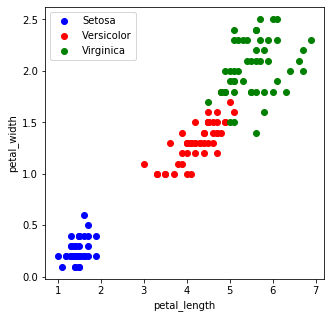

In [24]:
X = iris_red.iloc[:,:2]
y = iris_red['class']
plt.figure(figsize=(5,5))
plt.plot(X.loc[y==0].iloc[:,0], X.loc[y==0].iloc[:,1], "bo", label="Setosa")
plt.plot(X.loc[y==1].iloc[:,0], X.loc[y==1].iloc[:,1], "ro", label="Versicolor")
plt.plot(X.loc[y==2].iloc[:,0], X.loc[y==2].iloc[:,1], "go", label="Virginica")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.legend()
plt.show()

We now train Gaussian Naive Bayes on these data:

In [25]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X,y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
gnb.classes_

array([0, 1, 2])

The estimated class-specific means are: 

In [27]:
gnb.theta_

array([[1.462, 0.246],
       [4.26 , 1.326],
       [5.552, 2.026]])

For example, the average *petal_length* for the class *iris setosa* is 1.462, while the average *petal_width* for the class *iris virginica* is 2.062. We can also inspect the variances:

In [28]:
gnb.sigma_

array([[0.029556, 0.010884],
       [0.2164  , 0.038324],
       [0.298496, 0.073924]])

The predicted posterior probabilities of the classes for the first five training units are:

In [29]:
gnb.predict_proba(X[:5])

array([[1.00000000e+00, 9.39869627e-17, 6.56341701e-24],
       [1.00000000e+00, 9.39869627e-17, 6.56341701e-24],
       [1.00000000e+00, 3.57791653e-17, 2.34604033e-24],
       [1.00000000e+00, 3.30655295e-16, 2.49066098e-23],
       [1.00000000e+00, 9.39869627e-17, 6.56341701e-24]])

This result makes sense, as all the first five instances in the training dataset come from the *iris setosa* family. And their predictions: 

In [30]:
gnb.predict(X[:5])

array([0, 0, 0, 0, 0])

Last, let's plot the decision boundaries:

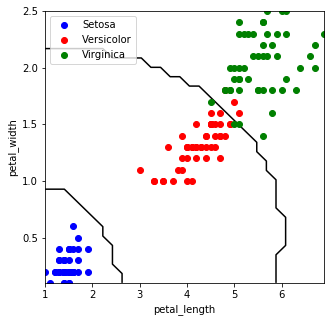

In [31]:
XX1, XX2 = np.meshgrid(np.linspace(X.iloc[:,0].min(), X.iloc[:,0].max(), 30), 
                       np.linspace(X.iloc[:,1].min(), X.iloc[:,1].max(), 30))
ZZ = gnb.predict(np.c_[XX1.ravel(), XX2.ravel()]).reshape(XX1.shape)
plt.figure(figsize=(5,5))
plt.contour(XX1, XX2, ZZ, levels=1, colors='k')
plt.plot(X.loc[y==0].iloc[:,0], X.loc[y==0].iloc[:,1], "bo", label="Setosa")
plt.plot(X.loc[y==1].iloc[:,0], X.loc[y==1].iloc[:,1], "ro", label="Versicolor")
plt.plot(X.loc[y==2].iloc[:,0], X.loc[y==2].iloc[:,1], "go", label="Virginica")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.legend()
plt.show()

## 4. Example with the Heart Dataset 
The Heart dataset is composed of mixed continuous and categorical features. The Naive Bayes models implemented in scikit-learn do not support such datasets. To estimate Naive Bayes with this dataset, we are going to follow the following strategy: 
* we will upload the original (non-preprocessed) dataset
* we will perform median imputation on the continuous features, and mode imputation on the categorical ones 
* we will discretize the continuous features by partitioning them into 5 bins (notice that this value can also be tuned)
* we will perform ordinal encoding of the categorical features
* we will merge the datasets, and train categorical Naive Bayes (with Laplace smoothing)  on these data
* the test data will also be transformed, and used for the evaluation of Naive Bayes

In [32]:
# 1. Data import and train-test set split (with same parameters used in the Data Preprocessing notebook)
from sklearn.model_selection import train_test_split
heart_data = pd.read_csv("data/heart_data/heart.csv")
X = heart_data.drop('AHD', axis=1)
y = heart_data['AHD']
y_num = pd.factorize(y)[0]
X.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_num, test_size=0.2, stratify=y_num, random_state=2)

In [33]:
# 2. Separate continuous from categorical (and binary) features
X_train_cat = X_train.select_dtypes(include=['object'])
X_test_cat = X_test.select_dtypes(include=['object'])
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
is_binary = [len(X_train_num[x].value_counts())==2 for x in X_train_num.columns]
X_train_cont = X_train_num.iloc[:, is_binary==np.repeat(False, len(is_binary))]
X_test_cont = X_test_num.iloc[:, is_binary==np.repeat(False, len(is_binary))]
X_train_bin = X_train_num.iloc[:, is_binary==np.repeat(True, len(is_binary))]
X_test_bin = X_test_num.iloc[:, is_binary==np.repeat(True, len(is_binary))]

In [34]:
# 3. Data Imputation
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cont_imp = pd.DataFrame(num_imputer.fit_transform(X_train_cont))
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat))
X_test_cont_imp = pd.DataFrame(num_imputer.transform(X_test_cont))
X_test_cat_imp = pd.DataFrame(cat_imputer.transform(X_test_cat))

In [35]:
# 4. Encoding Categorical Features 
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
X_train_cat_ord_enc = pd.DataFrame(ord_enc.fit_transform(X_train_cat_imp))
X_test_cat_ord_enc = pd.DataFrame(ord_enc.transform(X_test_cat_imp))

In [36]:
# 5. Discretizing Numeric Features - Use 5 bins per feature, uniformly partitioned
# Feature 4, 7 and 8 are not discretized, as they only take on a small number of values distinct values
from sklearn.preprocessing import KBinsDiscretizer
k_bins_disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform' )
X_train_cont_disc = pd.DataFrame(k_bins_disc.fit_transform(X_train_cont_imp))
X_test_cont_disc = pd.DataFrame(k_bins_disc.transform(X_test_cont_imp) )

In [37]:
# 6. Merging the datasets
X_train_cont_disc.index = X_train.index
X_train_cat_ord_enc.index = X_train.index 
X_test_cont_disc.index = X_test.index
X_test_cat_ord_enc.index = X_test.index 
y_train= pd.Series(y_train, index = X_train.index)
y_test = pd.Series(y_test, index = X_test.index)
X_train_processed = pd.concat([X_train_cont_disc,X_train_cat_ord_enc, X_train_bin], axis=1)
X_test_processed = pd.concat([X_test_cont_disc, X_test_cat_ord_enc, X_test_bin], axis=1 )
# Update variable names 
new_var_names = list(X_train_cont.columns)
new_var_names = new_var_names
new_var_names = new_var_names + list(X_train_cat)
new_var_names = new_var_names + list(X_train_bin.columns)
X_train_processed.columns = new_var_names
X_test_processed.columns = new_var_names
X_train_processed.head()

,ID,Age,RestBP,Chol,RestECG,MaxHR,Oldpeak,Slope,Ca,ChestPain,Thal,Sex,Fbs,ExAng
278,4.0,2.0,2.0,1.0,4.0,3.0,0.0,0.0,1.0,2.0,1.0,1,0,0
71,1.0,3.0,1.0,1.0,0.0,3.0,0.0,2.0,3.0,0.0,2.0,1,1,0
235,3.0,2.0,1.0,1.0,4.0,1.0,2.0,2.0,3.0,0.0,1.0,1,0,1
217,3.0,1.0,2.0,1.0,4.0,3.0,0.0,2.0,0.0,0.0,1.0,0,0,1
302,4.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1,0,0


The dataset is ready for Categorical Naive Bayes. Let's train it and explore its output.

In [38]:
# 7. Implementing Categorical Naive Bayes
cnb = CategoricalNB(alpha=1)
cnb.fit(X_train_processed, y_train)

CategoricalNB(alpha=1, class_prior=None, fit_prior=True)

In [39]:
# Class-specific counts: 
cnb.category_count_

[array([[29., 23., 27., 28., 24.],
        [19., 23., 25., 18., 26.]]), array([[20., 37., 43., 23.,  8.],
        [ 8., 20., 40., 38.,  5.]]), array([[29., 60., 35.,  6.,  1.],
        [17., 50., 31., 10.,  3.]]), array([[43., 67., 18.,  2.,  1.],
        [24., 71., 14.,  2.,  0.]]), array([[79.,  0.,  1.,  0., 51.],
        [45.,  0.,  2.,  0., 64.]]), array([[ 0.,  6., 24., 65., 36.],
        [ 4., 19., 39., 40.,  9.]]), array([[105.,  22.,   3.,   1.,   0.],
        [ 52.,  30.,  21.,   6.,   2.]]), array([[85.,  0., 39.,  0.,  7.],
        [28.,  0., 73.,  0., 10.]]), array([[102.,  20.,   0.,   6.,   3.],
        [ 38.,  30.,   0.,  27.,  16.]]), array([[29., 54., 34., 14.],
        [84., 15.,  6.,  6.]]), array([[  4., 106.,  21.],
        [  9.,  29.,  73.]]), array([[61., 70.],
        [21., 90.]]), array([[109.,  22.],
        [ 92.,  19.]]), array([[111.,  20.],
        [ 54.,  57.]])]

In [40]:
# Evaluation on training set:
cnb.score(X_train_processed, y_train)

0.8677685950413223

In [41]:
# Evalutation on test set:
cnb.score(X_test_processed, y_test)

0.8524590163934426

Despite the loss of information in the continuous data occured with the discretization step, Naive Bayes leads to a test set accuracy that is comparable with the one of Logistic Regression and Linear SVM.

* As an exercise, try to tune the parameter $\alpha$ and the number of bins for the discretization of continuous features (with cross-validation), and try to see if they can further improve the test accuracy of Naive Bayes. 